In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import myML
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from tqdm.notebook import tqdm
import unidecode
import netCDF4 as nc

# Loading

In [2]:
## Load name database
file_location = 'input files/databases/worldcities.csv'
worldcities = pd.read_csv(file_location, delimiter=';')
print(worldcities.head())

  city_ascii      lat       lng  population
0      Tokyo  35.6839  139.7744  39105000.0
1    Jakarta  -6.2146  106.8451  35362000.0
2      Delhi  28.6667   77.2167  31870000.0
3     Manila  14.6000  120.9833  23971000.0
4  Sao Paulo -23.5504  -46.6339  22495000.0


In [3]:
## Load CSVs
definitions = pd.read_csv('input files/definition.csv', delimiter=';')
definitions = definitions[['R','G','B']].to_numpy()
definitions

array([[  0,   0,   0],
       [  0,   0,   0],
       [171, 128,   0],
       ...,
       [243, 243, 244],
       [243, 243, 243],
       [242, 243, 243]], dtype=int64)

In [4]:
locators = {}
with open('input files/city_locators.txt', 'r') as file:
    contents = file.read().splitlines()
    for line in range(8, len(contents)-4, 6):
        ids = int(contents[line].split("=")[1])
        
        temp = contents[line+1].split(" ")[1:-1]
        locators[ids] = (int(temp[0]), 6144-int(temp[2]))

In [5]:
names = {}
with open(f'input files/provincenames_l_english.yml', 'r') as file:
    contents = file.read().splitlines()
    for line in range(1, len(contents)):
        names[line] = contents[line].split('"')[1]

In [6]:
imgProvs = Image.open('input files/provinces.png')
display(imgProvs)

# Functions

In [7]:
def squaredDistance(pointA, pointB):
    dist, dim = 0, len(pointA)
    for d in range(dim):
        dist += (pointA[d]-pointB[d])**2
    return dist

def nearestCity(xy: tuple, locators: dict):
    distances = {}
    for ids in locators:
        distances[ids] = squaredDistance(xy, locators[ids])

    nearest = min(distances, key=distances.get)
    return nearest

# Latitude to y

In [8]:
# Train a neural network with: input the latitude of the point, output the true (manually and visually obtained) Y pixel in the image
x_train = pd.DataFrame([-55.30,-52.37,-49.26,-47.20,-45.03,-42.97,-37.15,-30.27,-23.51,-20.82,-18.44,-13.88,-11.32,-7.83,-6.00,-4.686,-2.19,0.80,2.53,3.86,6.26,8.09,9.58,13.05,16.01,18.03,19.88,25.15,29.16,33.93,35.96,38.94,41.1,44.38,45.88,48.64,51.63,54.93,56.98,59.98,63.44,67.82,70.96],columns=['latitude'])
y_train = pd.DataFrame([5887,  5753,  5613,  5519,  5419,  5326,  5063,  4750,  4440,  4316,  4208,  4002,  3885,  3728, 3643, 3583,  3472, 3334,3256,3194,3086,3003,2931,2777, 2644, 2553, 2464,  2226, 2044, 1826, 1733, 1597, 1501,1350, 1283, 1156, 1021, 872,  775,  640,  481,  282,  141],columns=['y coord'])

pd.concat([x_train,y_train], axis=1).head(3)

latitude  y coord
0    -55.30     5887
1    -52.37     5753
2    -49.26     5613

In [ ]:
#Cross-validation using the training samples to find the elbow of the curve (to avoid under or overfitting)
epochs = 300        #Times that the entire dataset is used to train the NN
lr = 0.001          #Learning rate
lambd = 0           #Regularization term
activation = ['ReLU','ReLU','ReLU']
lossname = 'MSE'
optimizer = 'Adam'

generations=100
popsize=10

ni = 1
nf = 8
yplot_train = np.zeros(nf-ni+1)
for i in tqdm(range(nf-ni+1)):
    nodes = [1, i+ni, i+ni, 1]

    neuralnetwork = myML.ANN(nodes, activation, lossname)
    neuralnetwork.defineNorm('Output', maximum=[85], minimum=[-85])
    neuralnetwork.defineNorm('Input', maximum=[6144], minimum=[0])
    _ = neuralnetwork.trainGA(y_train, x_train, generations=generations, popsize=popsize, tqdmDisable=True)
    costs = neuralnetwork.train(y_train, x_train, epochs, optimizer, lr, lambd, tqdmDisable=True)
    yplot_train[i] = costs[-1]
    if i>0:
        if costs[-1]>yplot_train[i-1]: yplot_train[i] = yplot_train[i-1]

plt.plot(range(ni,nf+1),yplot_train,label='Training set error')
plt.xlabel('Nº of neurons in hidden layer')
plt.ylabel('Cost function error')
plt.legend(loc='best')
plt.show()

Generations:   0%|          | 0/100 [t-00:00, eta-?, ?it/s]

Epochs:   0%|          | 0/2000 [t-00:00, eta-?, ?it/s]

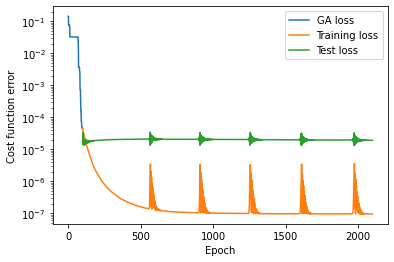

In [10]:
#Lat to y coords
epochs = 2000       #Times that the entire dataset is used to train the NN
lr = 0.001          #Learning rate
lambd = 0           #Regularization term
activation = ['ReLU','ReLU','ReLU']
lossname = 'MSE'
optimizer = 'Adam'
nodes = [1, 3, 3, 1]

generations=100
popsize=30

lat_to_y = myML.ANN(nodes, activation, lossname)
lat_to_y.defineNorm('Input', maximum=x_train.max(), minimum=x_train.min())
lat_to_y.defineNorm('Output', maximum=y_train.max(), minimum=y_train.min())

gaCost = lat_to_y.trainGA(x_train, y_train, generations=generations, popsize=popsize)
costs = lat_to_y.train(x_train, y_train, epochs, optimizer, lr, lambd, batchSize=0)

plt.plot(range(generations),gaCost, label='GA loss')
plt.plot(range(generations,generations+epochs),costs[0], label='Training loss')
plt.plot(range(generations,generations+epochs),costs[1], label='Test loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Cost function error')
plt.show()

In [12]:
temp = np.array(worldcities['lng'])
worldcities['x'] = ((0.5+temp/360)*16384).T

temp = np.array(worldcities['lat'])
worldcities['y'] = lat_to_y.run(temp)
worldcities.head(2)

city_ascii      lat       lng  population             x            y
0      Tokyo  35.6839  139.7744  39105000.0  14553.288249  1746.551634
1    Jakarta  -6.2146  106.8451  35362000.0  13054.639218  3653.320970

# Y to latitude

Generations:   0%|          | 0/100 [t-00:00, eta-?, ?it/s]

Epochs:   0%|          | 0/2000 [t-00:00, eta-?, ?it/s]

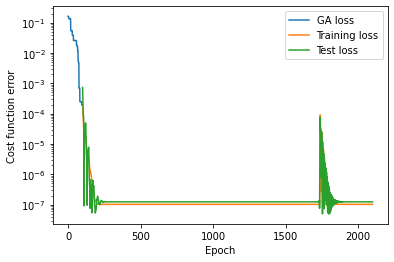

In [15]:
#y to lat coords
epochs = 2000       #Times that the entire dataset is used to train the NN
lr = 0.001          #Learning rate
lambd = 0           #Regularization term
activation = ['ReLU','ReLU','ReLU']
lossname = 'MSE'
optimizer = 'Adam'
nodes = [1, 2, 2, 1]

generations=100
popsize=30

y_to_lat = myML.ANN(nodes, activation, lossname)
y_to_lat.defineNorm('Input', maximum=y_train.max(), minimum=y_train.min())
y_to_lat.defineNorm('Output', maximum=x_train.max(), minimum=x_train.min())

gaCost = y_to_lat.trainGA(y_train, x_train, generations=generations, popsize=popsize)
costs = y_to_lat.train(y_train, x_train, epochs, optimizer, lr, lambd, batchSize=0)

plt.plot(range(generations),gaCost, label='GA loss')
plt.plot(range(generations,generations+epochs),costs[0], label='Training loss')
plt.plot(range(generations,generations+epochs),costs[1], label='Test loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Cost function error')
plt.show()

# Coordinates

In [16]:
latlong = {}
for ids in locators:
    x, y = locators[ids]

    long = 360*(x/16384-0.5)

    lat = y_to_lat.run(np.array(y))[0,0]

    latlong[ids] = (lat,long)

# Names

In [17]:
used = []
for i in tqdm(range(len(worldcities))):
    city = worldcities.iloc[i,:]
    nearest = nearestCity((city['x'],city['y']), locators)

    if nearest not in used:
        names[nearest] = city['city_ascii']
        used.append(nearest)

  0%|          | 0/42905 [00:00<?, ?it/s]

# Areas

In [18]:
pixels, counts = np.unique(np.array(imgProvs).reshape(-1,3), axis=0, return_counts=True)

In [55]:
def area_coef(lat, long, deltaLat, deltaLong): #Area in sq miles
    earthR = 6378.137

    d1 = np.sin(0.5*deltaLat)**2
    d1 = 2*earthR*np.arctan2(np.sqrt(d1),np.sqrt(1-d1))

    d2 = np.cos(lat)**2*np.sin(0.5*deltaLong)**2
    d2 = 2*earthR*np.arctan2(np.sqrt(d2),np.sqrt(1-d2))

    area = d1*d2 #Area in km2
    area *= 0.3861
    return area

inhabitables = list(range(4883,5692+1))
inhabitables.append(1)
areas = {}
diagonals = {}
for ids in tqdm(latlong):
    if ids in inhabitables: continue

    provColor = tuple(definitions[ids])
    for i, color in enumerate(pixels):
        if provColor==tuple(color):
            break
    count = counts[i]

    x, y = locators[ids]
    deltaLong = np.deg2rad(abs(360*((x+1)/16384-0.5)-360*(x/16384-0.5)))
    deltaLat = y_to_lat.run(np.array([y+1,y]))
    deltaLat = np.deg2rad(abs(deltaLat[0,0]-deltaLat[1,0]))

    lat = np.deg2rad(latlong[ids][0])
    long = np.deg2rad(latlong[ids][1])

    areas[ids] = round(count*area_coef(lat, long, deltaLat, deltaLong), 3)
    diagonals[ids] = np.sqrt(areas[ids])

  0%|          | 0/4881 [00:00<?, ?it/s]

# CEDA, precipitation, temperature and frost days

In [58]:
import numpy.ma as ma

def searchMap(lat, long, maskedArray):
    lat = round((lat+90)*2)
    long = round((long+180)*2)
    
    if maskedArray.mask[lat,long]:
        radius = 0
        while True:
            radius+=1
            x = long
            y = max(lat - radius,0)
            if maskedArray.mask[y,x]==False: break

            x = max(long - radius,0)
            y = lat
            if maskedArray.mask[y,x]==False: break

            x = long
            y = min(lat + radius,360-1)
            if maskedArray.mask[y,x]==False: break

            x = min(long + radius,720-1)
            y = lat
            if maskedArray.mask[y,x]==False: break

            if radius>100: print(ids)
        return maskedArray.data[y, x]
    else:
        return maskedArray.data[lat, long]

### Average yearly rainfall in inches

In [59]:
preData = nc.Dataset('input files/ceda/cru_ts4.05.1901.1910.pre.dat.nc')
preData['pre']

<class 'netCDF4._netCDF4.Variable'>
float32 pre(time, lat, lon)
    long_name: precipitation
    units: mm/month
    correlation_decay_distance: 450.0
    _FillValue: 9.96921e+36
    missing_value: 9.96921e+36
unlimited dimensions: time
current shape = (120, 360, 720)
filling on

In [60]:
mmRain = np.zeros((360,720))
for year in range(10):
    for month in range(12):
        mmRain = np.add(mmRain, preData['pre'][year*12+month,:,:])
mmRain = mmRain / 10

rainfall = {}
for ids in latlong:
    if ids in inhabitables: continue

    lat, long = latlong[ids][0], latlong[ids][1]
    rainfall[ids] = 0.03937007874*round(searchMap(lat, long, mmRain),1)

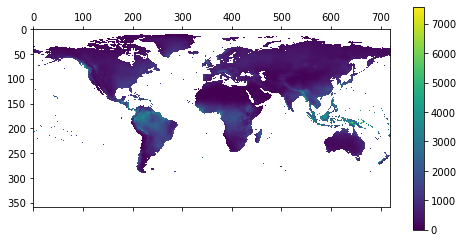

In [61]:
plt.matshow(np.flip(mmRain, axis=0))
plt.colorbar()

### Average yearly temperature

In [62]:
tmpData = nc.Dataset('input files/ceda/cru_ts4.04.1901.1910.tmp.dat.nc')
tmpData['tmp']

<class 'netCDF4._netCDF4.Variable'>
float32 tmp(time, lat, lon)
    long_name: near-surface temperature
    units: degrees Celsius
    correlation_decay_distance: 1200.0
    _FillValue: 9.96921e+36
    missing_value: 9.96921e+36
unlimited dimensions: time
current shape = (120, 360, 720)
filling on

In [63]:
celsius = np.zeros((360,720))
for year in range(10):
    for month in range(12):
        celsius = np.add(celsius, tmpData['tmp'][year*12+month,:,:])
celsius = celsius / 120

temperature = {}
for ids in latlong:
    if ids in inhabitables: continue

    lat, long = latlong[ids][0], latlong[ids][1]
    temperature[ids] = round(searchMap(lat, long, celsius),1)

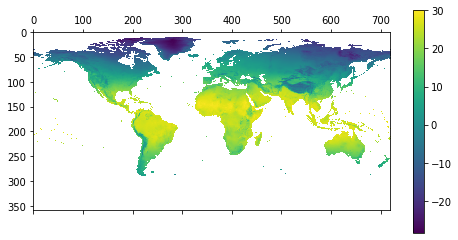

In [64]:
plt.matshow(np.flip(celsius, axis=0))
plt.colorbar()

### Average frost days per year

In [65]:
frsData = nc.Dataset('input files/ceda/cru_ts4.04.1901.1910.frs.dat.nc')
frsData['frs']

<class 'netCDF4._netCDF4.Variable'>
float32 frs(time, lat, lon)
    long_name: ground frost frequency
    units: days
    correlation_decay_distance: 750.0
    _FillValue: 9.96921e+36
    missing_value: 9.96921e+36
unlimited dimensions: time
current shape = (120, 360, 720)
filling on

In [66]:
frosts = np.zeros((360,720))
for year in range(10):
    for month in range(12):
        frosts = np.add(frosts, frsData['frs'][year*12+month,:,:])
frosts = frosts / 10

frostsDays = {}
for ids in latlong:
    if ids in inhabitables: continue

    lat, long = latlong[ids][0], latlong[ids][1]
    frostsDays[ids] = round(searchMap(lat, long, frosts))

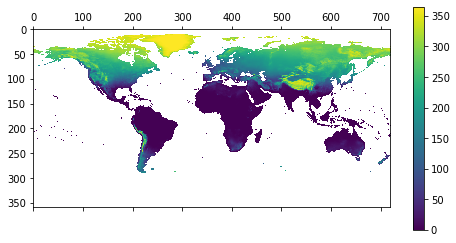

In [67]:
plt.matshow(np.flip(frosts, axis=0))
plt.colorbar()

In [68]:
climate = {'Arid':[], 'Warm':[], 'Mild':[], 'Normal':[], 'Severe':[]}
for ids in frostsDays:
    if frostsDays[ids]<110: 
        if rainfall[ids]<10: climate['Arid'].append(ids)
        else: climate['Warm'].append(ids)
    elif frostsDays[ids]<150: climate['Mild'].append(ids)
    elif frostsDays[ids]<190: climate['Normal'].append(ids)
    else: climate['Severe'].append(ids)
print(len(climate['Arid']))
print(len(climate['Warm']))
print(len(climate['Mild']))
print(len(climate['Normal']))
print(len(climate['Severe']))

278
2355
1271
648
329


# Elevation

In [69]:
eleData = nc.Dataset('input files/ceda/elev.0.25-deg.nc')
eleData['data']

<class 'netCDF4._netCDF4.Variable'>
int16 data(time, lat, lon)
    long_name: meters, from 5-min data
    add_offset: 0.0
    scale_factor: 1.0
    missing_value: 32767
    units: meters, from 5-min data
unlimited dimensions: time
current shape = (1, 720, 1440)
filling on, default _FillValue of -32767 used

In [70]:
height = eleData['data'][0,:,:] * 3.28084
def searchElevation(lat, long, maskedHeight):
    lat = round((90-lat)*4)
    
    if long<0: long = round(1440+long*4)
    else: long = round(4*long)
    
    return max(0,round(maskedHeight.data[lat, long-1]))

elevation = {}
for ids in latlong:
    if ids in inhabitables: continue

    lat, long = latlong[ids][0], latlong[ids][1]
    elevation[ids] = searchElevation(lat, long, height)

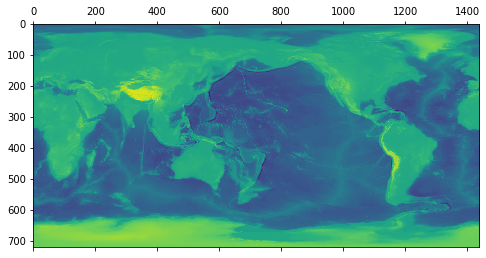

In [71]:
plt.matshow(eleData['data'][0,:,:])

In [73]:
2, names[2], f'{areas[2]} sq.miles', f'{diagonals[2]} miles', locators[2], latlong[2], f'{rainfall[2]} inches of rain', f'{temperature[2]} degrees celcius',\
f'{frostsDays[2]} frost days', f'{elevation[2]}ft above sea level'

(2,
 'Elliot Lake',
 '23771.687 sq.miles',
 '154.18069593823995 miles',
 (4407, 1260),
 (46.37081550517141, -83.16650390625),
 '30.82677165342 inches of rain',
 '2.7 degrees celcius',
 '204 frost days',
 '541ft above sea level')

# Saving

In [74]:
# Province parameters
climateKeys = {'Arid':-1, 'Warm':0, 'Mild':1, 'Normal':2, 'Severe':3}
with open('output files/provSetup.txt','w') as file:
    file.write('namespace = provSetup\n\nprovSetup.1 = {\n\ttype = country_event\n\n\thidden = yes\n\n\timmediate = {\n')
    for ids in names:
        if ids in inhabitables: continue
        file.write(f'\t\tp:{ids} = {"{"} ')
        #XY
        file.write(f'set_variable = {"{"} name = dat_x value = {locators[ids][0]} {"}"} ')
        file.write(f'set_variable = {"{"} name = dat_y value = {6144-locators[ids][1]} {"}"} ')
        #latitude-longitude
        file.write(f'set_variable = {"{"} name = dat_lat value = {round(latlong[ids][0],2)} {"}"} ')
        file.write(f'set_variable = {"{"} name = dat_lng value = {round(latlong[ids][1],2)} {"}"} ')
        #Area in square miles
        file.write(f'set_variable = {"{"} name = dat_area value = {areas[ids]} {"}"} ')
        #Square root of the area
        file.write(f'set_variable = {"{"} name = dat_dist value = {round(diagonals[ids],1)} {"}"} ')
        #Rain in inches
        file.write(f'set_variable = {"{"} name = dat_rain value = {round(rainfall[ids],2)} {"}"} ')
        file.write(f'set_variable = {"{"} name = rainlocal value = {round(rainfall[ids],2)} {"}"} ')
        #Temperature in degrees celsius
        file.write(f'set_variable = {"{"} name = dat_temp value = {temperature[ids]} {"}"} ')
        file.write(f'set_variable = {"{"} name = templocal value = {temperature[ids]} {"}"} ')
        #Elevation in feet above sea level
        file.write(f'set_variable = {"{"} name = dat_elev value = {elevation[ids]} {"}"} ')
        #Winter harshness
        for id1 in climate:
            for id2 in climate[id1]:
                if id2==ids:
                    file.write(f'set_variable = {"{"} name = dat_type value = flag:{id1} {"}"} ') 
                    break
        file.write('}\n')
    file.write('\t}\n\n}')

In [33]:
# Winter harshness
n = 50
with open('output files/climate.txt','w') as file:
    file.write('# Empty\n\nmild_winter = LIST {\n\t')
    i=0
    for ids in climate['Mild']:
        i+=1
        if i % n ==0: file.write('\n\t')
        file.write(f'{ids} ')
    file.write('\n}\n\nnormal_winter = LIST {\n\t')
    i=0
    for ids in climate['Normal']:
        i+=1
        if i % n ==0: file.write('\n\t')
        file.write(f'{ids} ')
    file.write('\n}\n\nsevere_winter = LIST {\n\t')
    i=0
    for ids in climate['Severe']:
        i+=1
        if i % n ==0: file.write('\n\t')
        file.write(f'{ids} ')
    file.write('\n}\n\narid = LIST {\n\t')
    i=0
    for ids in climate['Arid']:
        i+=1
        if i % n ==0: file.write('\n\t')
        file.write(f'{ids} ')
    file.write('\n}')


In [34]:
### Write localization. This is not useful unless you want to overwrite manual changes to localization
with open('output files/provincenames_l_english.yml', 'w') as file:
    file.write('l_english:\n')
    for ids in names:
        file.write(f' PROV{ids}:0 "{names[ids]}"\n')

# Biome classification

In [381]:
biomes = {
    'Tundra': (147,167,172),
    'Taiga': (91,143,82),
    'Cold desert': (146,126,48),
    'Shrubland': (179,124,6),
    'Temperate forest': (44,137,160),
    'Temperate rainforest': (10,84,109),
    'Desert': (200,113,55),
    'Savanna': (151,165,39),
    'Rainforest': (7,83,48)
}

In [393]:
nPoints = 600
bList = list(biomes.keys())
x_train, y_train2, y_train = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
whittaker = np.array(Image.open('input files/whittaker.png').convert('RGB'))
for i, biome in enumerate(biomes):
    color = biomes[biome]
    y, x = np.where((whittaker[:,:,0] == color[0]) & (whittaker[:,:,1] == color[1]) & (whittaker[:,:,2] == color[2]))
    index = np.random.choice(a=len(x), size=nPoints)

    x_train = pd.concat([x_train,pd.DataFrame({'Temperature': x[index]*20/399-10, 'Rain': -y[index]*2000/379+4649.077})], axis=0)
    y_train2 = pd.concat([y_train2,pd.DataFrame({'Biome': [biome]*nPoints})], axis=0)

x_train = x_train.reset_index(drop=True)
y_train2 = y_train2.reset_index(drop=True)
y_train = pd.get_dummies(y_train2.Biome)
y_train = y_train[bList]
pd.concat([x_train,y_train], axis=1).head(3)

Temperature        Rain  Tundra  Taiga  Cold desert  Shrubland  \
0    -1.929825  707.124493       1      0            0          0   
1    -5.388471   26.385707       1      0            0          0   
2    -5.388471  337.731354       1      0            0          0   

   Temperate forest  Temperate rainforest  Desert  Savanna  Rainforest  
0                 0                     0       0        0           0  
1                 0                     0       0        0           0  
2                 0                     0       0        0           0

In [363]:
import importlib
importlib.reload(myML)

<module 'myML' from 'q:\\Pablo\\Proyectos\\Python\\3imperatorrelated\\1provextrainfo\\myML.py'>

  0%|          | 0/12 [00:00<?, ?it/s]

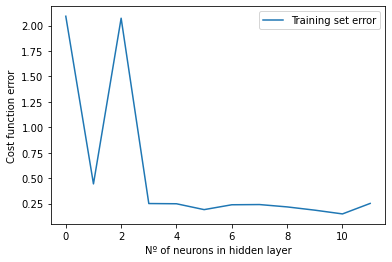

In [431]:
#Cross-validation using the training samples to find the elbow of the curve (to avoid under or overfitting)
epochs = 400        #Times that the entire dataset is used to train the NN
lr = 0.1          #Learning rate
lambd = 0           #Regularization term
activation = ['ReLU','ReLU','softmax']
lossname = 'logloss'
optimizer = 'Adam'

generations=100
popsize=10

ni = 1
nf = 12
step = 1
yplot_train = [[0]*int((nf-ni+1)/step) for _ in range(2)]
for i in tqdm(range(0, nf-ni+1, step)):
    nodes = [2, i+ni, i+ni, 9]

    neuralnetwork = myML.ANN(nodes, activation, lossname)
    neuralnetwork.defineNorm('Input', maximum=x_train.max(), minimum=x_train.min())
    
    _ = neuralnetwork.trainGA(x_train, y_train, generations=generations, popsize=popsize, tqdmDisable=True)
    costs = neuralnetwork.train(x_train, y_train, epochs, optimizer, lr, lambd, tqdmDisable=True, batchSize=0)
    yplot_train[0][i], yplot_train[1][i] = costs[0][-1], costs[1][-1]

plt.plot(range(0, nf-ni+1, step),yplot_train[0],label='Training set error')
#plt.plot(range(0, nf-ni+1, step),yplot_train[1],label='Test set error')
plt.xlabel('Nº of neurons in hidden layer')
plt.ylabel('Cost function error')
plt.legend(loc='best')
plt.show()

Generations:   0%|          | 0/100 [t-00:00, eta-?, ?it/s]

Epochs:   0%|          | 0/2000 [t-00:00, eta-?, ?it/s]

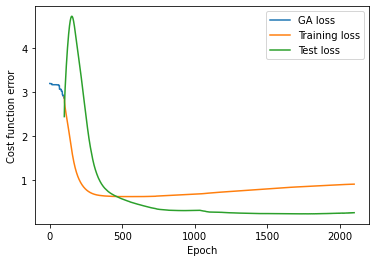

In [434]:
epochs = 2000       #Times that the entire dataset is used to train the NN
lr = 0.001           #Learning rate
lambd = 0           #Regularization term
activation = ['ReLU','ReLU','softmax']
lossname = 'logloss'
optimizer = 'Adam'
nodes = [2, 4, 4, 9]

generations=100
popsize=30

neuralnetwork = myML.ANN(nodes, activation, lossname)
neuralnetwork.defineNorm('Input', maximum=x_train.max(), minimum=x_train.min())

gaCost = neuralnetwork.trainGA(x_train, y_train, generations=generations, popsize=popsize)
costs = neuralnetwork.train(x_train, y_train, epochs, optimizer, lr, lambd, batchSize=16)

plt.plot(range(generations),gaCost, label='GA loss')
plt.plot(range(generations,generations+epochs),costs[0], label='Training loss')
plt.plot(range(generations,generations+epochs),costs[1], label='Test loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
#plt.yscale('log')
plt.ylabel('Cost function error')
plt.show()

In [435]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, np.round(neuralnetwork.run(x_train)))

0.8731481481481481

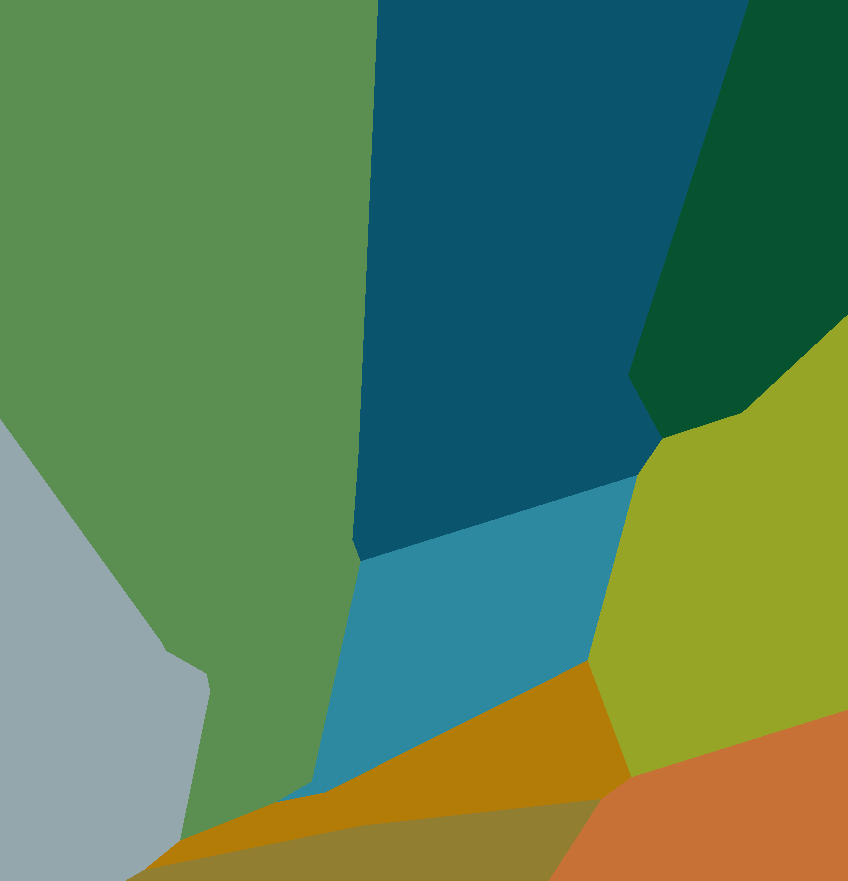

In [436]:
xtest = pd.DataFrame()
temp = [[],[]]
for y in range(whittaker.shape[0]):
    for x in range(whittaker.shape[1]):
        temp[0].append(x*20/399-10)
        temp[1].append(-y*2000/379+4649.077)
xtest['Temperature'] = temp[0]
xtest['Rainfall'] = temp[1]

ytest = neuralnetwork.run(xtest)

count = 0
for y in range(whittaker.shape[0]):
    for x in range(whittaker.shape[1]):
        biomeKey = np.argmax(ytest[count])

        whittaker[y,x,:] = biomes[bList[biomeKey]]
        count+=1

im = Image.fromarray(whittaker)
display(im)
im.save('ANN_whittaker.png')

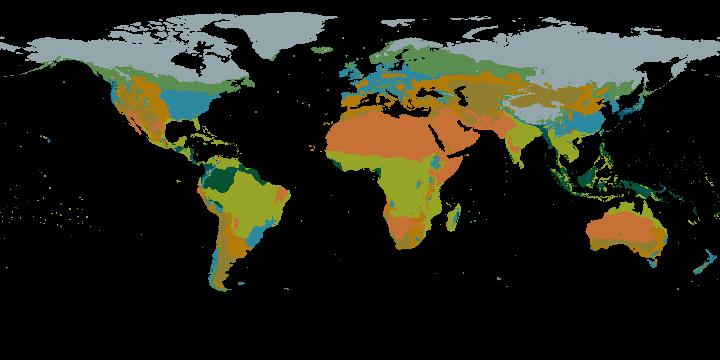

In [437]:
biomeMap = np.zeros((360,720,3), dtype=np.uint8)
xtest = pd.DataFrame()
temp, coords = [[],[]], []
for y in range(biomeMap.shape[0]):
    for x in range(biomeMap.shape[1]):
        if mmRain.mask[y,x]==True or celsius.mask[y,x]==True: continue
        
        coords.append((y,x))
        temp[0].append(celsius.data[y,x])
        temp[1].append(mmRain.data[y,x])
xtest['Temperature'] = temp[0]
xtest['Rainfall'] = temp[1]

ytest = neuralnetwork.run(xtest)

for i in range(len(coords)):
        y, x = coords[i]
        biomeKey = np.argmax(ytest[i])

        biomeMap[y,x,:] = biomes[bList[biomeKey]]

biomeMap = Image.fromarray(np.flip(biomeMap, axis=0))
biomeMap.save('biomeMap.png')
display(biomeMap)

# Tree/Rock layers
With advanced real data (temperature, rainfall, accurate conversion to lat long) we can have a better model to paint tree / rock / grasses layers